# Creating a Neural Network From Scratch (Only Using Numpy)
## About the Project
The purpose of this project is to create a simple neural network from scratch by using only the Python package Numpy to enhance my understanding of neural networks, the maths behind it all, and how they are implemented.
This specific neural network aims to decipher 28 x 28 pixel images of handwritten numbers. 
The network will consist of an input layer, a hidden layer, and an output layer. 
With ten neurons in both the hidden layer and the output layer.
I will try to classify the data from the famous digit MNIST dataset using this neural network.

## About the Dataset
The dataset is part of a Kaggle competition found [here](https://www.kaggle.com/c/digit-recognizer/data)

The dataset consists of 42,000 28 x 28 pixel handwritten digit images.
There are 785 features in the dataset:
* **label**: *The true number of the image*
* **pixel**: *The other 784 features correspond to one of the pixels of the image*

## Import Packages

In [104]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## Load Dataset

In [13]:
data = pd.read_csv("path/Number_Data.csv")
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# We need to work with arrays so that we can do the calculations required for the neural network
data = np.array(data)

m, n = data.shape
# m = number of rows/number of images
# n = number of columns/number of pixels.

### Split Data into Train and Test

In [133]:
# Shuffle images randomly
np.random.shuffle(data)

# Select the first 1,000 images for the test data
data_test = data[0:1000].T 
# Transpose data so that each image is in one column instead of one row.
# This is required for dot products
Y_test = data_test[0] # This contains the labels for each image. the true values.
X_test = data_test[1:n] # This contains the pixel values for every image.
X_test = X_test / 255

# Select the rest of the 41,000 images for the train data
data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255

## Creating Functions for the Neural Networks
**Functions:**
1. one_hot(Y): *Encodes predicted outcomes*
2. init_params(): *Outputs random parameters*
3. ReLU(Z): *Activation function to ensure non-linearity*
4. deriv_ReLU(Z): *Derivative of activation function used in back propagation*
5. softmax(Z): *Activation function that ouputs probabilities*
6. forward_prop(W1, b1, W2, b2, X): *Produce predicted output*
7. back_prop(Z1, A1, Z2, A2, W2, X, Y): *Calculates loss from each parameter*
8. update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha): *Changes parameters with respect to loss contribution*
11. gradient_descent(X, Y, iterations, alpha): *Essentialy the neural network*

### one_hot(Y)
This function is used to calculate the loss of the neural network in back propogation. If the specified label is 4 all predicted outcomes as 4 will be encoded as 1. 

Input: 
- Y: True label of each image

Output:
- one_hot_Y: Encoded values of predicted labels of each image

In [68]:
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1)) # Creates the correctly sized matrix
    one_hot_Y[np.arange(Y.size), Y] = 1 # For each row specified in the label in Y and set it to 1.
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

### init_params()

Assigns random weights and biases for all nodes in the neural network.

Inputs: None

Outputs: 
- W1: weights for each input for each node in the hidden layer 
- b1: biases for each node in the hidden layer
- W2: weights for each input for each node in the output layer
- b2: biases for each node in the output layer

In [32]:
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10)
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

### ReLU(Z) + deriv_ReLU(Z)
The Rectified Linear Unit (ReLU) is an activation function where any values above 0 are unchanged and any below 0 are changed to 0.
Without the use of this function the neural network will work as a combination of linear functions thus becoming a large linear regression model.

Input:
- Z: unactivated input values 

Output:
- A: Activated values 

In [94]:
def ReLU(Z):
    return np.maximum(Z, 0) 
    # Goes through each element.
    # If Z > 0 = Z, Z < 0 = 0

def deriv_ReLU(Z):
    return Z > 0

### softmax(Z)
The softmax function is another activation function, however it is quite different to ReLU as it converts the outputs of the hidden layer into probabilites where 1 is absolute certainity and 0 is no chance. Therefore, the neural network can classify the output as one fo the 10 digits.

Inputs:
- Z: unactivated input values for output layer

Outputs:
- A: activated values for output layer

In [82]:
def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

### forward_prop(W1, b1, W2, b2, X)
This forward propagation function will input the randomly initialised weights and biases and produce an ouptut of predicted outcomes.

Inputs: 
- W1: weights for each input for each node in the hidden layer 
- b1: biases for each node in the hidden layer
- W2: weights for each input for each node in the output layer
- b2: biases for each node in the output layer
- X: Pixel values of the images

Outputs:
- Z1: unactivated values of hidden layer
- A1: activated input values of hidden layer
- Z2: unactivated values of input from output layer
- A2: predictions of labels for each image

In [40]:
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

### back_prop(Z1, A1, Z2, A2, W2, Y)
This back propagation function will use the predicted outcomes from the forward propogation function to calculate the loss from the true labels. The function then precedes to calcualte how much each of the parameters contributed to this loss by differentiating each calculation. 

Inputs:
- Z1: unactivated values of input layer
- A1: activated input values
- Z2: unactivated values of input from hidden layer
- A2: predictions of labels for each image
- W1: weights for each input for each node in the hidden layer 
- W2: weights for each input for each node in the output layer
- X: Pixel values of the images
- Y: True labels of each image

Outputs:
- dW1: The error contributed by the weights in the input layer
- db1: The error contributed by the biases in the input layer
- dw2: The error contributed by the weights in hidden layer
- db2: the error contributed by the biases in the hidden layer

In [96]:
def back_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    m = Y.size
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1/m * dZ2.dot(A1.T)
    db2 = 1/m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * deriv_ReLU(Z1)
    dW1 = 1/m * dZ1.dot(X.T)
    db1 = 1/m * np.sum(dZ1)
    return dW1, db1, dW2, db2

### update_params(W1, b1, W2, b2, dW1, db1, dW2. db2, alpha)
This function updates the parameters with respect to their error contribution so that total loss is minimised in the predicted output for the next run of the neural network.

Inputs:
- W1: weights for each input for each node in the hidden layer 
- b1: biases for each node in the hidden layer
- W2: weights for each input for each node in the output layer
- b2: biases for each node in the output layer
- dW1: The error contributed by the weights in the input layer
- db1: The error contributed by the biases in the input layer
- dw2: The error contributed by the weights in hidden layer
- db2: the error contributed by the biases in the hidden layer
- alpha: The learning rate of the neural network

Outputs:
- W1: weights for each input for each node in the hidden layer 
- b1: biases for each node in the hidden layer
- W2: weights for each input for each node in the output layer
- b2: biases for each node in the output layer

In [47]:
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    return W1, b1, W2, b2

### get_predictions(A2) + get_accuracy(predictions, Y)
These functions display the performance of the neural network.
The get_predictions function simply returns the predictions made by the neural network.
The get_accuracy function simply calculates the proportion of the predictions that are correct (match with the true label)

In [50]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

### gradient_descent(X, Y, iterations, alpha)
The gradient_descent function is essentialy the neural network. It combines previous functions to initalise random paramters and then continuously goes through a loop of creating an output, calculating loss, and updating parameters to minimise loss and provide (hopefully) accurate predictions.

Inputs:
- X: Pixel values of the images
- Y: True labels of each image
- iterations: The number of times the neural network loops through forward and backward propagation
- alpha: The learning rate of the neural network

Outputs:
- W1: The optimal weights for each input for each node in the hidden layer 
- b1: The optimal biases for each node in the hidden layer
- W2: The optimal weights for each input for each node in the output layer
- b2: The optimal biases for each node in the output layer

In [98]:
def gradient_descent(X, Y, iterations, alpha):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = back_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print("Accuracy: ", get_accuracy(predictions, Y))
    return W1, b1, W2, b2

## Running the Neural Network

In [181]:
# Training the neural network with the train data to find the optimal parameters.
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 500, 0.1)

Iteration:  0
[4 6 7 ... 0 1 6] [4 1 7 ... 4 4 1]
Accuracy:  0.10004878048780488
Iteration:  10
[7 7 7 ... 0 1 3] [4 1 7 ... 4 4 1]
Accuracy:  0.16229268292682927
Iteration:  20
[4 1 7 ... 4 1 1] [4 1 7 ... 4 4 1]
Accuracy:  0.25514634146341464
Iteration:  30
[4 1 7 ... 4 1 1] [4 1 7 ... 4 4 1]
Accuracy:  0.32821951219512197
Iteration:  40
[0 1 7 ... 4 1 1] [4 1 7 ... 4 4 1]
Accuracy:  0.38970731707317074
Iteration:  50
[0 1 7 ... 4 1 1] [4 1 7 ... 4 4 1]
Accuracy:  0.4453658536585366
Iteration:  60
[0 1 7 ... 4 1 1] [4 1 7 ... 4 4 1]
Accuracy:  0.4937560975609756
Iteration:  70
[0 1 7 ... 4 1 1] [4 1 7 ... 4 4 1]
Accuracy:  0.5364878048780488
Iteration:  80
[4 1 7 ... 4 1 1] [4 1 7 ... 4 4 1]
Accuracy:  0.5702926829268292
Iteration:  90
[4 1 7 ... 4 1 1] [4 1 7 ... 4 4 1]
Accuracy:  0.5980243902439024
Iteration:  100
[4 1 7 ... 4 1 1] [4 1 7 ... 4 4 1]
Accuracy:  0.6203414634146341
Iteration:  110
[4 1 7 ... 4 1 1] [4 1 7 ... 4 4 1]
Accuracy:  0.6384878048780488
Iteration:  120
[4 1 7

### Examples

In [189]:
# Functions that essentialy show one example of the neural network's predicted outcome compared to the true label
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_predictions(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation = "nearest")
    plt.show()

Prediction:  [5]
Label:  5


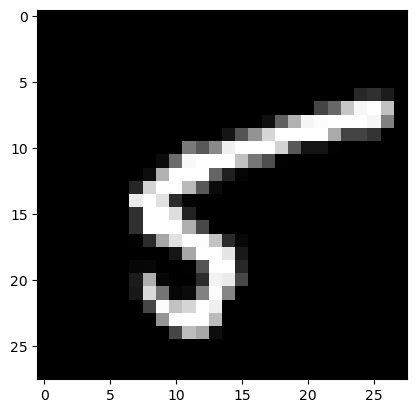

In [193]:
test_predictions(15, W1, b1, W2, b2)

In [195]:
# Seeing how the model works on the test data
pred_test = make_predictions(X_test, W1, b1, W2, b2)
get_accuracy(pred_test, Y_test)

[3 7 0 5 0 7 4 2 9 0 6 8 1 1 6 8 9 6 1 2 1 1 9 9 5 2 5 7 9 2 5 1 5 8 1 3 0
 1 8 6 2 7 1 0 8 9 9 2 6 5 4 1 2 6 5 6 9 4 8 5 2 8 0 7 2 6 0 6 3 1 2 6 8 2
 3 2 1 8 5 2 7 9 9 2 5 0 6 9 5 8 8 2 8 3 3 5 0 6 2 6 6 7 4 8 4 7 2 2 5 1 4
 2 3 7 2 2 6 8 1 8 8 4 4 1 8 9 3 9 2 1 6 0 2 4 3 9 3 6 1 0 9 6 5 3 3 6 0 0
 0 5 2 9 4 1 8 7 4 1 2 6 6 6 9 3 6 6 0 8 1 0 6 5 6 9 6 3 9 4 2 2 0 3 8 3 3
 8 5 6 6 6 7 0 1 2 8 5 0 9 5 6 8 1 9 2 1 6 4 0 8 9 7 4 6 2 5 1 0 4 3 8 6 9
 5 7 4 4 9 9 4 3 3 1 7 9 5 1 5 9 4 3 3 7 4 5 6 9 0 7 7 4 8 4 4 8 8 2 2 8 4
 6 2 9 2 1 4 8 4 6 2 1 0 9 8 6 1 8 0 4 1 2 1 4 1 1 4 1 8 5 8 7 4 0 8 1 5 4
 2 0 7 9 1 1 9 2 0 1 2 1 8 7 1 0 3 9 4 6 8 7 4 9 7 5 1 0 2 3 6 3 3 7 0 2 3
 2 1 6 4 9 5 4 0 9 1 0 8 6 0 1 7 7 3 3 3 7 9 4 0 3 9 2 2 2 6 2 7 2 4 5 7 1
 5 1 6 2 8 1 3 6 0 6 8 1 6 5 2 8 6 4 6 0 9 5 7 8 6 9 2 3 1 1 4 3 6 0 3 6 6
 7 5 8 7 3 9 7 4 4 7 5 5 6 5 1 4 1 9 7 8 8 2 5 4 0 7 5 4 1 5 2 7 0 7 9 0 8
 7 5 0 2 5 8 1 5 7 7 7 5 2 2 0 4 7 8 6 7 0 2 6 8 5 7 7 8 1 7 2 0 1 9 2 1 8
 4 8 8 6 0 1 8 5 7 8 9 3 

0.852

#### Accuracy on Test data: ~85%